<ipython-input-1-743441a60fd6>:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  multivariate_data.fillna(method='ffill', inplace=True)
<ipython-input-1-743441a60fd6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multivariate_data.fillna(method='ffill', inplace=True)


Mean Squared Error for USD (AM): 96.62511292235867
Mean Squared Error for GBP (AM): 74.42519003746317
Mean Squared Error for EURO (AM): 61.7418319078434


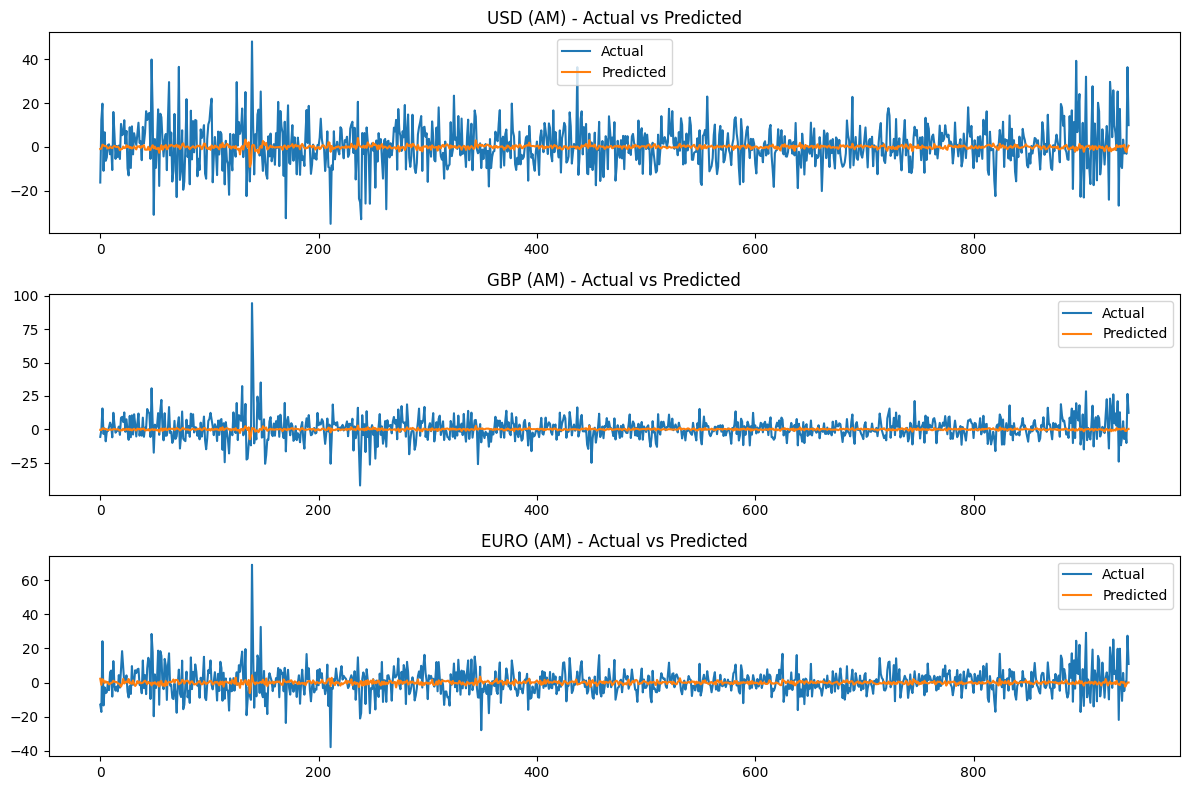

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Step 1: Load and preprocess the dataset
data = pd.read_csv('/content/gold (1).csv')  # Replace with your file path
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Select relevant columns
selected_columns = ['USD (AM)', 'GBP (AM)', 'EURO (AM)']
multivariate_data = data[selected_columns]

# Handle missing values (e.g., forward fill)
multivariate_data.fillna(method='ffill', inplace=True)

# Stationarity: Apply differencing to make the data stationary
multivariate_data_diff = multivariate_data.diff().dropna()

# Step 2: Create lagged data
def create_lagged_features(data, lags):
    lagged_data = {}
    for lag in range(1, lags + 1):
        lagged_data[f"lag_{lag}"] = data.shift(lag)
    return pd.concat(lagged_data.values(), axis=1)

# Set the number of lags
p = 3  # Choose based on intuition or lag selection techniques
lagged_data = create_lagged_features(multivariate_data_diff, p)
lagged_data = lagged_data.dropna()

# Step 3: Split data into training and test sets
train_size = int(len(lagged_data) * 0.8)
train = lagged_data.iloc[:train_size]
test = lagged_data.iloc[train_size:]

# Define X (features) and y (targets)
X_train = train.iloc[:, :-len(selected_columns)]  # Lagged features
y_train = train.iloc[:, -len(selected_columns):]  # Current values

X_test = test.iloc[:, :-len(selected_columns)]
y_test = test.iloc[:, -len(selected_columns):]

# Step 4: Estimate VAR Coefficients
coefficients = np.linalg.lstsq(X_train, y_train, rcond=None)[0]

# Step 5: Make Predictions
def forecast(X, coefficients):
    return np.dot(X, coefficients)

y_pred = forecast(X_test, coefficients)

# Step 6: Evaluate the Model
for i, col in enumerate(selected_columns):
    mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
    print(f"Mean Squared Error for {col}: {mse}")

# Step 7: Visualize Results
plt.figure(figsize=(12, 8))
for i, col in enumerate(selected_columns):
    plt.subplot(len(selected_columns), 1, i + 1)
    plt.plot(y_test.iloc[:, i].values, label='Actual')
    plt.plot(y_pred[:, i], label='Predicted')
    plt.title(f"{col} - Actual vs Predicted")
    plt.legend()
plt.tight_layout()
plt.show()
